# Classification.ipynb
Date: November 29th, 2018  
Course: ECSE415, McGill University  
Authors:  
*Shawn Vosburg  
Tristan Bouchard  
Alex Masciotra  
Nayem Alam  
Thomas Philippon *

## NOTE: The classification files folder must be found in the same folder as this code. 

In [1]:
#Import necessary libraries. Strategy: Find HoG features of each image and build SVM with them.
#For second classifier, try Kmeans or Kneighboors
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import  random as rand
from sklearn import svm

#from sklearn.neighbors import KNeighborsClassifier

#Declare Constants
CLASSIFY_DIM = (128,128)   #Size of the training images

### Loading and resizing images && Compute HOG features of all images.

In [2]:
def HoGFromImage(img,cs,bs,nb):
    """ This function takes in an image array and HoG param and returns the computed histogram for the image array
        img = image array. all images must be same resolution. 
        cs = cell size in pixel x pixel (height x width)
        bc = bin size in cell x cell (height x width)
        nb = number of bins

    """

    # create HoG Object
    # winSize is the size of the image cropped to an multiple of the cell size
    hog = cv2.HOGDescriptor(_winSize=(img.shape[1] // cs[1] * cs[1],
                                      img.shape[0] // cs[0] * cs[0]),
                            _blockSize=(bs[1] * cs[1],
                                        bs[0] * cs[0]),
                            _blockStride=(cs[1], cs[0]),
                            _cellSize=(cs[1], cs[0]),
                            _nbins=nb)
    
    
    n_cells = (img.shape[0] // cs[0], img.shape[1] // cs[1])
        

    # Compute HoG features
    hog_feats = hog.compute(img)\
                   .reshape(n_cells[1] - bs[1] + 1,
                            n_cells[0] - bs[0] + 1,
                            bs[0], bs[1], nb) \
                   .transpose((1, 0, 2, 3, 4))  # index blocks by rows first

    # hog_feats now contains the gradient amplitudes for each direction,for each cell of its group for each group.
    # Indexing is by rows then columns.

    # computation for BlockNorm
    gradients = np.full((n_cells[0], n_cells[1], 8), 0, dtype=float)
    cell_count = np.full((n_cells[0], n_cells[1], 1), 0, dtype=int)

    #Add each contributions to the histogram.
    for off_y in range(bs[0]):
        for off_x in range(bs[1]):
            gradients[off_y:n_cells[0] - bs[0] + off_y + 1,
                      off_x:n_cells[1] - bs[1] + off_x + 1] += \
                hog_feats[:, :, off_y, off_x, :]
            cell_count[off_y:n_cells[0] - bs[0] + off_y + 1,
                       off_x:n_cells[1] - bs[1] + off_x + 1] += 1

    # Average gradients
    gradients /= cell_count
    return gradients

In [3]:
#Import training images
folder = "./MIO-TCD-Classification/train/"
vehicleDir  = [                                  #Main Directory of Training images
    #"articulated_truck",        #10346 imgs
    #"background",               #160000 imgs
    "bicycle",                  #2284 imgs
    "bus",                      #10316 imgs
    #"car",                      #260518 imgs
    "motorcycle",               #1982 imgs
    "non-motorized_vehicle",    #1751 imgs
    "pedestrian",               #6262 imgs
    #"pickup_truck",             #50906 imgs
    "single_unit_truck",        #5120 imgs
    #"work_van"                 #9679 imgs
]                 
#Some vehicletypes are commented out as they take too much time to load. After writing code, will remove comment.

vehicleTypes = {}                                #This is the main hash that will map the vehicles type to a number. Maps string to index.
vehicleImgArr,vehicleLabels,hogArr = [],[],[]
idx = 0

#Build Hash Table
for bucket in os.listdir(folder):
    vehicleTypes[bucket] = idx
    idx +=1

#HOG features parameters
cell_size = (16,16)  # h x w in pixels #Changed from 4x4 to 16x16 to speed up process. 
block_size = (4,4)  # h x w in cells
nbins = 8  # number of orientation bins

#Loop across directory to fetch all images
for typeName in vehicleDir:
    vehicleTypeDir = folder + typeName+"/"
    print("Presently loading & finding HOG features of " + str(len(os.listdir(vehicleTypeDir))) + " images from: " + typeName,end="")
    presentTime = time.time()
    
    #fetch images
    for imgPath in os.listdir(vehicleTypeDir):
        img = cv2.imread(vehicleTypeDir+imgPath)
        img = cv2.resize(img,CLASSIFY_DIM)                          #Resize images so that they are all CLASSIFY_DIM in size
        #vehicleImgArr.append(img)                                  #Commented this out to save processing time. 
        vehicleLabels.append(vehicleTypes[typeName])                #Have a seperate array with the labels.
        hogArr.append(HoGFromImage(img,cell_size,block_size,nbins)) #Find Hog Features
    endTime = time.time()
    print(". (Time taken: ", endTime - presentTime,"secs)")
hogArr = np.asarray(hogArr)
vehicleLabels = np.asarray(vehicleLabels)

#Print out report:
print("Total Number of images:",len(hogArr))

Presently loading & finding HOG features of 2284 images from: bicycle. (Time taken:  3.437800168991089 secs)
Presently loading & finding HOG features of 10316 images from: bus. (Time taken:  20.822654247283936 secs)
Presently loading & finding HOG features of 1982 images from: motorcycle. (Time taken:  2.661879777908325 secs)
Presently loading & finding HOG features of 1751 images from: non-motorized_vehicle. (Time taken:  2.753631830215454 secs)
Presently loading & finding HOG features of 6262 images from: pedestrian. (Time taken:  8.034777879714966 secs)
Presently loading & finding HOG features of 5120 images from: single_unit_truck. (Time taken:  8.718675374984741 secs)
Total Number of images: 27715


### Preview of Image and its HOG features

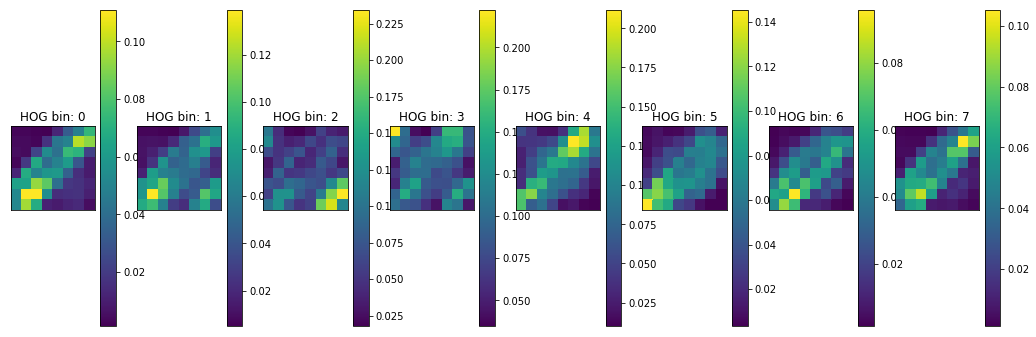

In [4]:
# Preview
test = 1001
plt.figure(figsize = (20,20))
for bin in range(nbins):
    plt.subplot(192+bin)
    plt.pcolor(hogArr[test][:, :, bin%nbins])
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')
    title = "HOG bin: " +  str(bin%nbins)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.colorbar()
plt.show()

### Classifier #1: SVM

In [5]:
#Class to hold the feature data and the label
class labeledData():
    def __init__(self,data,label,num):
        self.data = data
        self.label = label
        self.num = num
        

In [6]:

#Reshape the data to be a NxD array
data = hogArr.reshape(len(hogArr),-1)
labels = vehicleLabels.reshape(len(vehicleLabels),-1)

#Create a randomized array 
dataAndLabel = [labeledData(data[i],labels[i],i) for i in range(len(data))]
dataAndLabel = np.asarray(dataAndLabel) 
rand.shuffle(dataAndLabel)

#split data into training and testing arrays
k = 10
sizeOfBin = len(dataAndLabel) // k
labeledTest  = dataAndLabel[:sizeOfBin]  #Size of k
labeledTrain = dataAndLabel[sizeOfBin:]  #Size of 9k

#Creating Training and Testing Array
Train = [labeledTrain[i].data for i in range(len(labeledTrain))]
Train = np.asarray(Train)
TrainLabel= [labeledTrain[i].label for i in range(len(labeledTrain))]
TrainLabel = np.asarray(TrainLabel).reshape(-1)
Test = [labeledTest[i].data for i in range(len(labeledTest))]
Test = np.asarray(Test)
TestLabel= [labeledTest[i].label for i in range(len(labeledTest))]
TestLabel = np.asarray(TestLabel).reshape(-1)


print(TrainLabel.shape)
#Train SVM classifier
pTime = time.time()
clf = svm.SVC(gamma=0.001, C=100.)
clf.fit(Train, TrainLabel)
eTime = time.time()
print("Time taken to build classifier:",eTime-pTime)



(24944,)


SVC(C=100.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [8]:
predicted = clf.predict(Test)


In [13]:
total = predicted - TestLabel
print(""len(total[np.where(total != 0)]),"/",len(total),"=",len(total[np.where(total != 0)])/len(total))
print("Predicted:",predicted[:10])
print("Actual:",TestLabel[:10])

903 / 2771 = 0.3258751353302057
Predicted: [7 7 3 3 7 2 3 5 2 3]
Actual: [7 7 9 3 7 2 3 5 3 3]


### Classifier #2: Viola-Jones? Kmeans? K-NEarestNeighboor?